# Conceptual Design: Demo analysis

Exploration of use of Python/Jupyter to analyze and visualize structures discussed in Hervé Capart's _Conceptual Design_ class at NTU Civil Engineering.

### Preliminaries

In [32]:
import os
import numpy as np
import networkx as nx
from pprint import PrettyPrinter
pp = PrettyPrinter(indent=4).pprint
from matplotlib import pyplot as plt
# from mpl_toolkits import mplot3d
color_cycle = (plt.rcParams['axes.prop_cycle'].by_key()['color'])
color = lambda i: color_cycle[i % len(color_cycle)]
loop = lambda triangle: triangle + [triangle[0]]

In [33]:
import trimesh as tm
import pyvista as pv

In [34]:
from cdsn.model import Geometry as ModelGeometry
from cdsn.utils import e2d
from cdsn.plot import GraphingBase
from cdsn.save import create_directories, export_plots
viz = GraphingBase(font_name="Arial")

# Mesh construction

In [35]:
case_name = "simpleStructure1"
case_name = "standingTower1"

In [36]:
mg = ModelGeometry(case_name)

In [45]:
(
    mg.groundcommunity_nodes, 
    mg.d_appliedforce_trinodes, 
    mg.d_member_nodes, 
    mg.d_appliedforce_keynode,
)

(frozenset({51, 57, 145, 149, 156, 157, 158, 159, 160, 161, 162, 163}),
 {0: frozenset({2, 154, 155}),
  1: frozenset({15, 152, 153}),
  2: frozenset({46, 150, 151})},
 {0: frozenset({0, 5, 6, 7, 8, 9, 10, 11, 12, 13}),
  1: frozenset({0, 1, 2, 3, 4, 5}),
  2: frozenset({5, 13, 112, 119, 136, 137, 138, 139}),
  3: frozenset({8, 13, 28, 32, 42, 43, 44, 45}),
  4: frozenset({14, 15, 16, 17, 18, 19, 93, 97, 98, 99}),
  5: frozenset({20, 25, 106, 107, 108, 109, 110, 111}),
  6: frozenset({20, 21, 22, 23, 24, 25, 58, 59, 60, 61}),
  7: frozenset({26, 27, 28, 29, 30, 31, 32, 33}),
  8: frozenset({26, 31, 34, 35, 36, 37, 38, 39, 40, 41}),
  9: frozenset({31, 41, 130, 131, 132, 133, 134, 135}),
  10: frozenset({36, 41, 46, 47, 48, 49}),
  11: frozenset({50, 51, 52, 53, 54, 55, 56, 57}),
  12: frozenset({52, 56, 62, 63, 64, 65, 66, 67}),
  13: frozenset({58, 61, 77, 81, 88, 89, 90, 91}),
  14: frozenset({63, 67, 76, 77, 78, 79, 80, 81}),
  15: frozenset({68, 69, 70, 71, 72, 73, 74, 75}),
  16: 

In [38]:
mg.d_keynode_communities

{0: (1, 0),
 5: (3, 1),
 13: (4, 3),
 8: (4, 0),
 2: (2, 1),
 112: (26, 3),
 119: (26, 3),
 32: (9, 4),
 28: (9, 4),
 15: (6, 5),
 97: (22, 5),
 93: (22, 5),
 14: (23, 5),
 19: (23, 5),
 20: (8, 7),
 25: (8, 7),
 107: (25, 7),
 111: (25, 7),
 58: (17, 8),
 61: (17, 8),
 26: (10, 9),
 31: (11, 10),
 41: (12, 11),
 36: (12, 10),
 131: (27, 11),
 135: (27, 11),
 46: (13, 12),
 51: (15, 14),
 57: (15, 14),
 52: (16, 14),
 56: (16, 14),
 145: (20, 15),
 149: (20, 15),
 67: (18, 16),
 63: (18, 16),
 77: (18, 17),
 81: (18, 17),
 69: (20, 19),
 75: (20, 19),
 70: (21, 19),
 74: (21, 19),
 83: (22, 21),
 87: (22, 21),
 101: (24, 23),
 105: (24, 23),
 129: (27, 24),
 125: (27, 24),
 114: (26, 25),
 118: (26, 25)}

In [39]:
# adjacency_matrix = nx.adjacency_matrix(mg.graph).toarray()
# adjacency_matrix

In [40]:
pvmesh = viz.build_mesh(mg)
plotter = viz.plot_model_3d(pvmesh, backend="trame",)

Widget(value="<iframe src='http://localhost:63503/index.html?ui=P_0x164e63c70_0&reconnect=auto' style='width: …

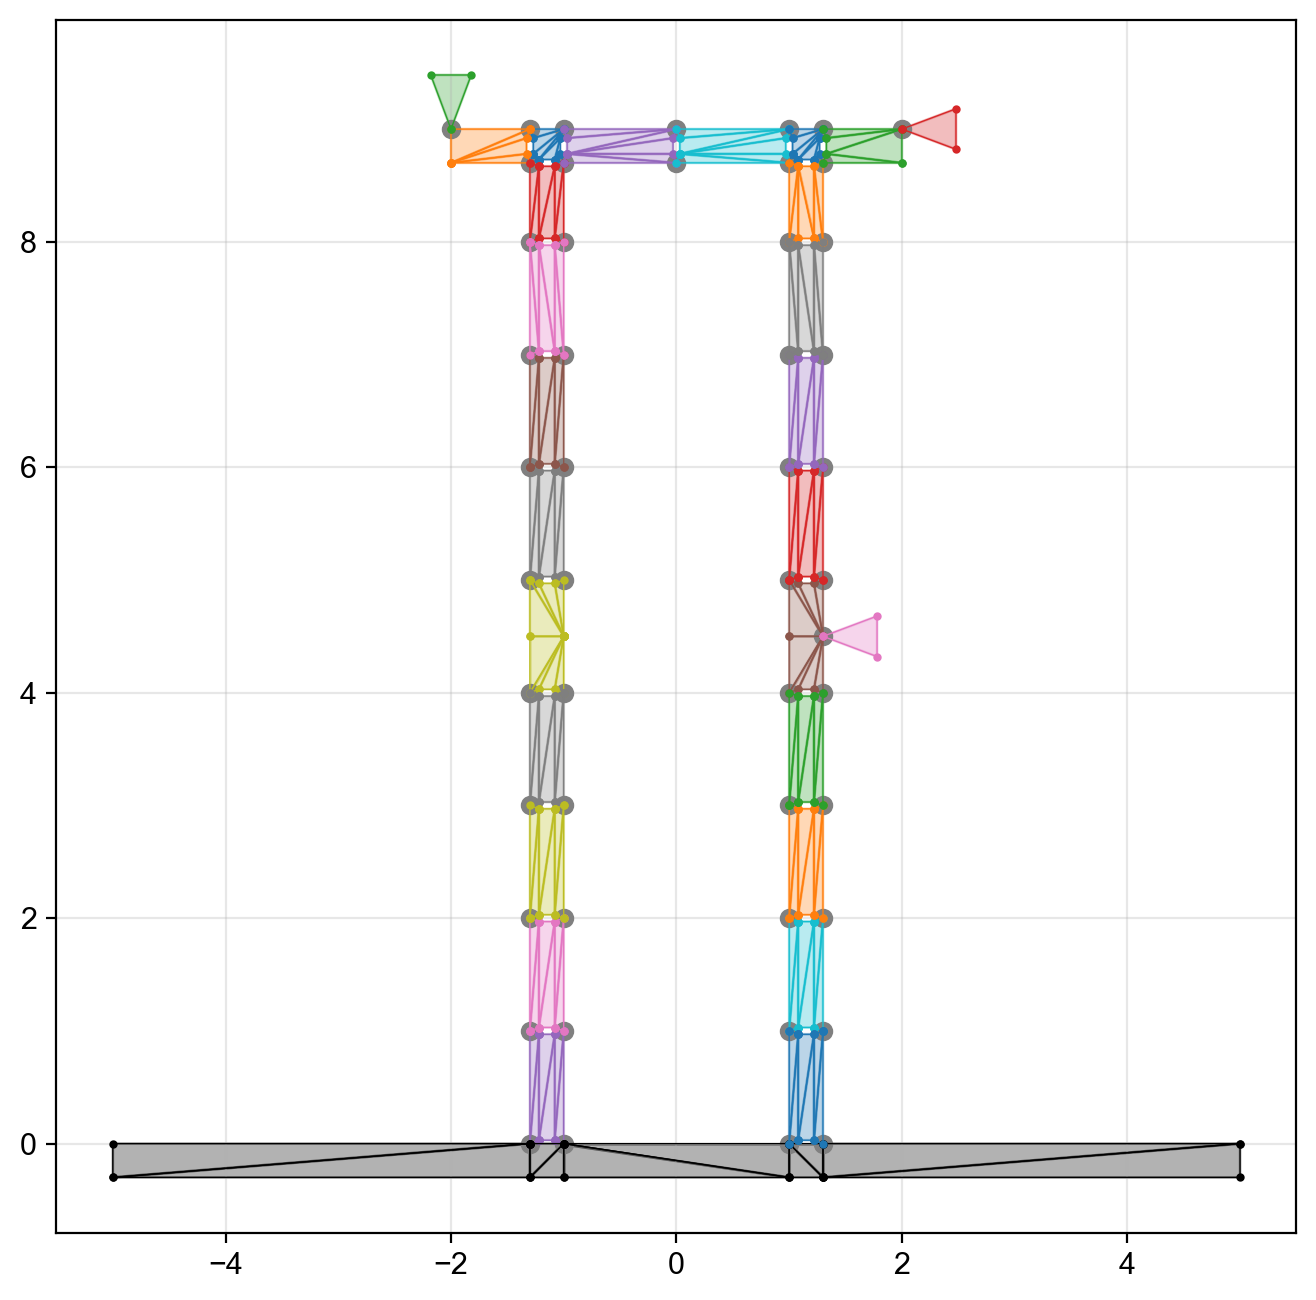

In [41]:
viz.plot_model(case_name, mg)

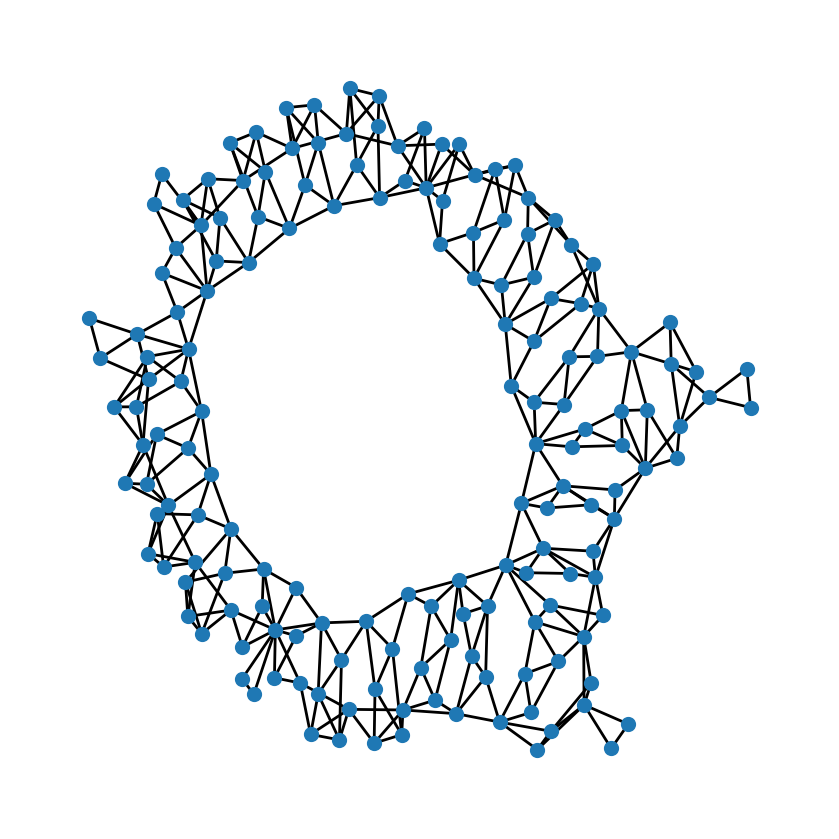

In [42]:
fig = viz.create_figure(fig_name=f"{case_name}_graph", fig_size=(4,4,),)
nx.draw_kamada_kawai(mg.graph, node_size=20,)

# Export

In [43]:
plots_dirname = "Plots"
plots_path = create_directories(("..",), plots_dirname)
for gr_ in [viz]:    
    export_plots( gr_.fdict, plots_path, file_types=["jpg"], dpi=100 )

In [44]:
plotter.export_html(os.path.join(plots_path, f"{case_name}.html"))